In [11]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [12]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_2.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(505, 408, 3)


In [13]:
# import os
# img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/pink.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
# img_orig = cv2.imread(img_path) 

# print (img_orig.shape)

In [14]:
# import os
# img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/face.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
# img_orig = cv2.imread(img_path) 

# print (img_orig.shape)

## 세그멘테이션(Segmentation)이 뭔가요?


이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

## 시멘틱 세그멘테이션(semantic segmentation)이란?

세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다. 오늘 다룰 세그멘테이션 방법이기도 하죠.



In [15]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [16]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [17]:
# img_resized, seg_map = MODEL.run(img_orig)
# print (img_orig.shape, img_resized.shape, seg_map.max())

In [18]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [19]:
def model_run(img_orig, label=15):
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 배경 흐리게 하기
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다.
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 흐린 배경과 원본 영상 합성
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

In [20]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'img_resized' is not defined

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.



In [ ]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

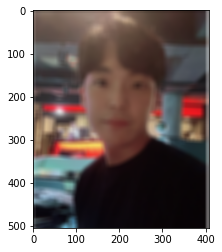

In [21]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'img_mask_up' is not defined

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
model_run(img_orig)

In [39]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pink.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(1440, 1080, 3)


(1440, 1080, 3) (513, 384, 3) 15


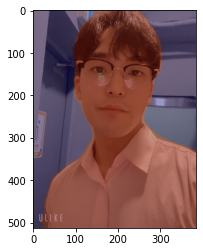

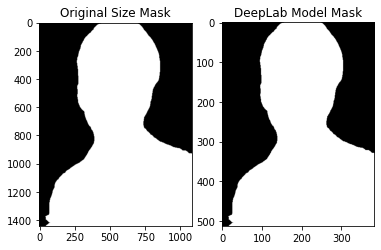

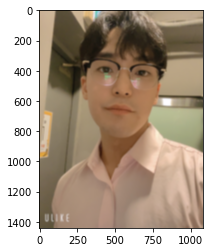

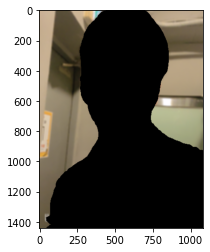

ValueError: operands could not be broadcast together with shapes (1440,1080,3) (1440,1080,3) (936,736,3) 

In [40]:
model_run(img_orig)


In [25]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/face.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(1337, 1079, 3)


(1337, 1079, 3) (513, 414, 3) 15


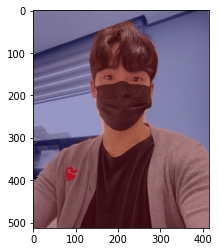

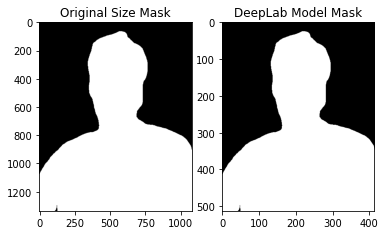

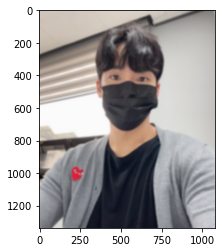

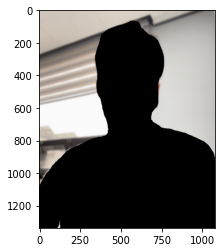

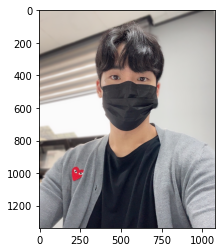

In [26]:
model_run(img_orig)


In [27]:

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(195, 259, 3)


(195, 259, 3) (386, 513, 3) 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


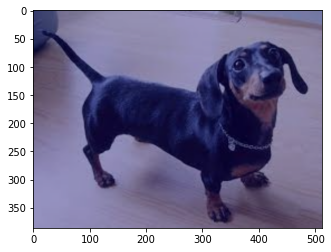

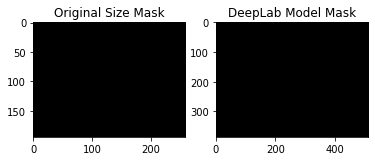

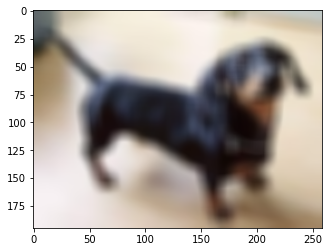

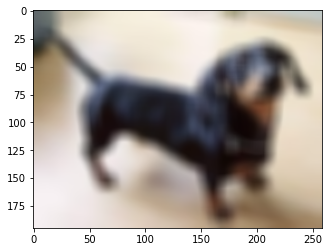

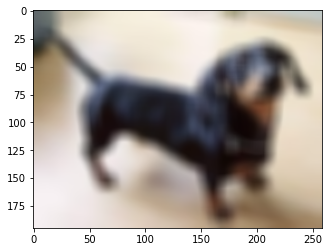

In [28]:
model_run(img_orig)


In [29]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/flower.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
background = cv2.imread(img_path)

In [30]:
img_orig.shape[:2]

(195, 259)

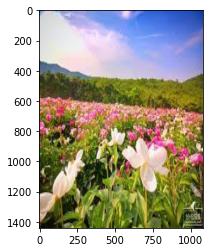

In [78]:
background = cv2.resize(background, (1080,1440), interpolation = cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.show()

In [79]:
def model_run(img_orig, label=15):
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 배경 흐리게 하기
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다.
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 흐린 배경과 원본 영상 합성
    img_concat = np.where(img_mask_color==255, img_orig, background)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

In [80]:
img_orig.shape

(1440, 1080, 3)

(1440, 1080, 3) (513, 384, 3) 15


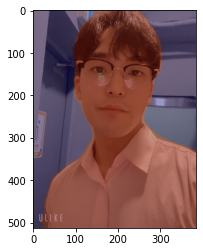

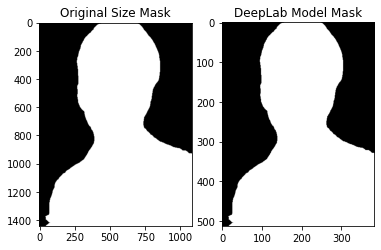

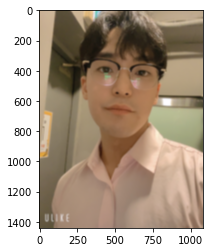

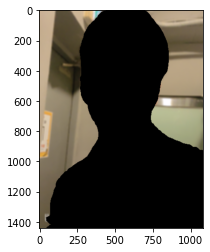

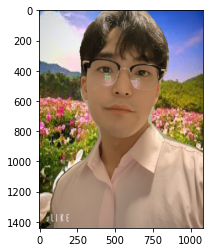

In [81]:
model_run(img_orig)